## Exploratory Plots of Digg Data

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# load in data
# votes = np.load("digg_votes.npy")
# friends = np.load("digg_friends.npy")

In [3]:
# extract all network information (compact dataframe of who is friends with whom)
# from https://github.com/geopanag/IMINFECTOR/blob/master/digg_preprocessing.py
def extract_network(file):
    friends = pd.read_csv(file,header=None)
    
    #--------- Remove self friendships
    friends = friends[friends[2]!=friends[3]]
    
    #--------- Repeat the reciprocal edges and append them
    reciprocal = friends[friends[0]==1]
    friends = friends.drop(0,1)
    reciprocal = reciprocal.drop(0,1)
    
    #---- Create the reciprocal edge for each pair
    tmp = reciprocal[2].copy()
    reciprocal[2] = reciprocal[3]
    reciprocal[3] = tmp

    #--------- Find the edges that already exist in the dataset as reciprocal, and remove them, 
    #--------- to avoid overwriting the currect time of the reciprocal edges that already exist
    to_remove = reciprocal.reset_index().merge(friends,left_on=[2,3],right_on=[2,3]).set_index('index').index
    reciprocal = reciprocal.drop(to_remove)
    
    friends = friends.append(reciprocal)
    friends[friends.duplicated([2,3],keep=False)] #-- this should be empty

    #----------- Store the weighted follow network
    friends.columns = ["time","a","b"]
    friends = friends[["a","b","time"]]
    return friends
#     friends.to_csv("../digg_network.txt",index=False,sep=" ",header=False)


# def extract_cascades(file):
#     #----------- Derive and store the train and test cascades
#     votes = pd.read_csv(file,header=None)
#     votes.columns = ["time","user","post"]
#     votes = votes.sort_values(by=["time"])
    
#     #---- Find the threshold after which the cascades are test cascades (final 20% of cascades)
#     start_times = votes.groupby("post")["time"].min() #--- take into consideration only the starting time of each cascade
#     start_times = start_times.sort_values()
#     no_test_cascades = round(20*len(start_times)/100)
#     threshold = min(start_times.tail(no_test_cascades))
#     #sum(start_times<threshold )/start_times.shape[0]
    
#     f_train = open("train_cascades.txt","w")
#     f_test = open("test_cascades.txt","w")

#     #--------- For each cascade
#     for i in votes["post"].unique():
#         print(i)
#         sub = votes[votes["post"]==i]
#         s = ""
    
#         #---- id:time, id:time etc...
#         for post in sub.sort_values(by=['time']).iterrows():
#             s = s+str(post[1]["user"])+" "+str(post[1]["time"])+";"#":"+str(post[1]["time"])+","
#         s = s[:-1]
    
#         #---- Check if it has started before or after the threshold
#         if(min(sub["time"])<threshold):
#             f_train.write(s+"\n")
#         else:
#             f_test.write(s+"\n")
#     f_train.close()
#     f_test.close()

In [4]:
file_friends = "digg2009/digg_friends.csv"
file_votes = "digg2009/digg_votes.csv"

friendships_df = extract_network(file_friends)
friendships_df = friendships_df.rename(columns={'a': 'source', 'b': 'target', 'time':'time'})

friendships_df.describe()
# digg_extract_cascades(file_casc)

,source,target,time
count,2.251166e+06,2.251166e+06,2.251166e+06
mean,1.687565e+05,1.704176e+05,1.218754e+09
std,9.800988e+04,9.838381e+04,4.173192e+07
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.286500e+04,8.489300e+04,1.207766e+09
50%,1.675950e+05,1.698670e+05,1.223239e+09
75%,2.549290e+05,2.576040e+05,1.236996e+09
max,3.362250e+05,3.362250e+05,1.247033e+09


In [25]:
friendship_plot_df = friendships_df[['source', 'target']].head(150)
friendship_plot_df.head()

,source,target
0,336224,266641
1,336224,215086
2,336224,151094
3,336224,59378
4,336224,8547


/Users/mdong/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


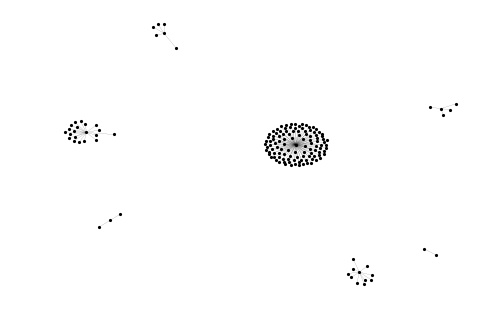

In [26]:
# plot of directed graph showing all friendships (currently taking a random sample due to size issues)
G = nx.convert_matrix.from_pandas_edgelist(friendship_plot_df)
options = {
    "node_color": "black",
    "node_size": 10,
    "linewidths": 0,
    "width": 0.1,
}
nx.draw(G, **options)
plt.show()

###### currently, scability of networkx is an issue; look into https://graph-tool.skewed.de/ if we want to graph more points

## Plot of social network graph for one story

In [38]:
votes = pd.read_csv(file_votes,header=None)
votes.columns = ['time','user','post']
votes = votes.sort_values(by=["time"])

In [71]:
story = 1
votes_story = votes.loc[votes['post'] == story]
votes_story = votes_story.drop(['post'], axis=1)
votes_story = votes_story.drop(['time'], axis=1)
# votes_story.head()

# define edges of social network graph by adding entries of adjacent users
votes_story = pd.concat([votes_story, votes_story[['user']].shift(-1)], axis=1, ignore_index=True)
votes_story.drop(votes_story.tail(1).index,inplace=True)
votes_story.columns = ['source', 'target']
votes_story.head()

,source,target
358,199749,87621.0
158,87621,308947.0
538,308947,314417.0
551,314417,126941.0
220,126941,65398.0


/Users/mdong/anaconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


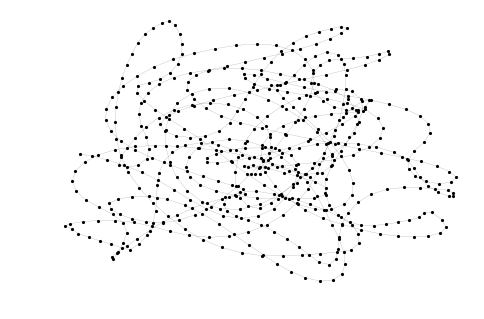

In [72]:
# plot social network graph for one story
G = nx.convert_matrix.from_pandas_edgelist(votes_story)
options = {
    "node_color": "black",
    "node_size": 10,
    "linewidths": 0,
    "width": 0.1,
}
nx.draw(G, **options)
plt.show()